# One-vs-all classifier 

This notebook provides the code to train a set of one-vs-all classifiers and compare their performance against each other. We choose a simple pipelie consisting of tf-idf static embeddings, lsa feature reduction and probabilistic modelling approaches. 

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import category_encoders as ce

import tools as tools

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

import joblib

In [2]:
'''import cleaned data'''
df = pd.read_csv(os.path.abspath(os.path.join('..', 'data/processed/'))+'/data_processed.csv')

In [3]:
'''one-hot-encode labels'''
df['sdg'] = df['sdg'].astype(str)
encoder = ce.OneHotEncoder(cols=['sdg'], use_cat_names=True)
df = encoder.fit_transform(df)
df.head(5)

,doi,text_id,text,sdg_5,sdg_3,sdg_6,sdg_2,sdg_8,sdg_4,sdg_7,...,sdg_15,sdg_11,sdg_12,sdg_9,sdg_14,labels_negative,labels_positive,agreement,text_clean,text_clean_spacy
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",1,0,0,0,0,0,0,...,0,0,0,0,0,1,8,0.777778,from a gender perspective paulgaard points out...,gender perspective paulgaard point labour mark...
1,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,0,1,0,0,0,0,0,...,0,0,0,0,0,1,8,0.777778,the average figure also masks large difference...,average figure mask large difference region ka...
2,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,3,1.000000,the israel oceanographic and limnological rese...,israel oceanographic limnological research sta...
3,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,3,1.000000,previous chapters have discussed ways to make ...,previous chapter discuss way food system suppo...
4,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,3,1.000000,prescription rates appear to be higher where l...,prescription rate appear high labour force par...


In [4]:
'''sort column names'''
df = df[list(sorted(df.columns.tolist()))]

In [5]:
categories = [
       'sdg_1', 'sdg_2','sdg_3', 'sdg_4', 'sdg_5',
       'sdg_6', 'sdg_7', 'sdg_8','sdg_9', 'sdg_10', 
       'sdg_11', 'sdg_12','sdg_13', 'sdg_14', 'sdg_15']

<AxesSubplot:>

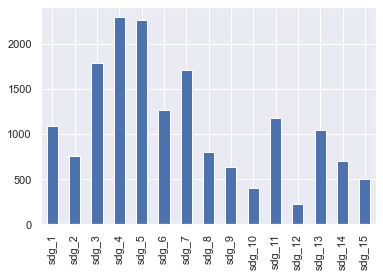

In [6]:
df[categories].sum(axis=0).plot.bar()

# Let's try the same without dimension reduction

In [ ]:
categories_used = []
scores = []
# iterate over categories and save best models:
    #Creating a dict of the models
model_dict = {
              'LR_balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'LR' : LogisticRegression(random_state = 3),
              'SDG' : SGDClassifier(random_state=3, loss='log'),
              'SDG_balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'RF': RandomForestClassifier(random_state=3),
              'Decsision_Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'KNB': KNeighborsClassifier()
                }

for category in categories: 

    print('processing:', category)
    
    X_train, X_test, y_train, y_test = train_test_split(df['text_clean_spacy'],                                                    
                                            df[category],
                                            test_size = .3,
                                            random_state = 1,
                                            stratify = df[category].values, 
                                            shuffle = True)

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                        min_df = 2, 
                                        max_df = .95)
    
    vect = tfidf_vectorizer.fit(X_train)
    X_train = vect.transform(X_train).toarray()
    X_test = vect.transform(X_test).toarray()


    #save vectorizer:
    filename = '../models/tf_idf/tf_idf_only/'+category+'_'+'vectorizer.sav'
    joblib.dump(vect, filename)    


    results, score = tools.model_score_df_all(model_dict, category, 'tf_idf_only', X_train, X_test, y_train, y_test)
    
    
    categories_used.append(category)
    scores.append(score)

    print('_____')

processing: sdg_1


In [ ]:
info_dict = dict(zip(categories_used, scores))

with open(os.path.abspath(os.path.join('..', 'data/processed/'))+"/tfidf_only_f1.pkl", 'wb') as handle:
    pickle.dump(info_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Let's try to build set of classifiers using tf-idf and lsa dimension reduction

In [ ]:
# iterate over categories and save best models:
    #Creating a dict of the models
model_dict = {
              'LR_balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'LR' : LogisticRegression(random_state = 3),
              'SDG' : SGDClassifier(random_state=3, loss='log'),
              'SDG_balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'RF': RandomForestClassifier(random_state=3),
              'Decsision_Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'GNB': GaussianNB(),
              'KNB': KNeighborsClassifier()}
    
for category in categories: 
   
    print('processing:', category)
    #Creating the features (tf-idf weights) for the processed text
    texts = df['text_clean_spacy'].astype('str')

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                    min_df = 2, 
                                    max_df = .95)
    X = tfidf_vectorizer.fit_transform(texts)     
    y = df[category].values


    filename = '../models/tf_idf/tf_idf_lsa/'+category+'_'+'vectorizer.sav'
    joblib.dump(tfidf_vectorizer, filename)    

    #Dimenionality reduction. Only using the 100 best features er category
    lsa = TruncatedSVD(n_components=100, 
                    n_iter=10, 
                    random_state=3)
    X = lsa.fit_transform(X)


    #save vectorizer:
    filename = '../models/tf_idf/tf_idf_lsa/'+category+'_'+'lsa.sav'
    joblib.dump(lsa, filename)  

    #Train test split with stratified sampling for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        stratify = y, 
                                                        random_state = 3)

    tools.model_score_df_all(model_dict, category, 'tf_idf_lsa', X_train, X_test, y_train, y_test)
    
    print('_____')
